Loading necessary libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

We first load the data. Among the columns, we only keep `primary_category`, `cleaned_title` and `MSC`.

In [2]:
data=pd.read_csv('./data/data.csv',index_col=False)
data=data[['primary_category','cleaned_title','MSC']]

#While loading, the lists under MSC column are loaded as strings.
data['MSC']=data['MSC'].apply(lambda x:eval(x))
data.head()

,primary_category,cleaned_title,MSC
0,math.NA,quasi monoton robust local continu piecewis po...,"[65N, 41A]"
1,math.AT,higher structur ration homotopi theori,"[55S, 16S, 18M, 18G, 55R, 55P, 55Q]"
2,math.QA,indecompos involut solut yang baxt equat finit...,"[81R, 16T, 20E, 20N]"
3,math.QA,kashiwara vergn solut degre degre,"[57K, 17B]"
4,math.QA,tetrahedron equat quantum cluster algebra,"[81R, 82B, 13F]"


Visualizing data: which primary categories have been more prevalent? 

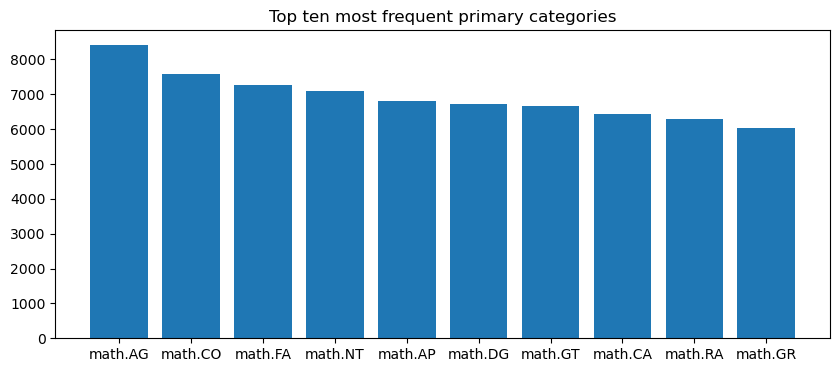

In [3]:
fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(1,1,1)

#Top 10 most frequent primary categories (bar chart)
ax.bar(x=data['primary_category'].value_counts().head(10).index, 
        height=data['primary_category'].value_counts().head(10))
ax.set_title('Top ten most frequent primary categories')

plt.show()

The labels (MSC classes) should be encoded. 

In [4]:
#To record the number of occurances of each class. 
dict_MSC={}
num_labels=[]
total_num_labels=0

for row in range(data.shape[0]):
    classes=data['MSC'][row]
    temp=len(classes)
    num_labels+=[temp]
    total_num_labels+=temp
    for MSC in classes:
        if MSC in dict_MSC.keys():
            dict_MSC[MSC]+=1
        else:
            dict_MSC[MSC]=1

print(f'The number of different labels is {len(dict_MSC)}.\n')
print(f'The average number of labels per entry is {round(total_num_labels/data.shape[0],2)}.')


data=pd.concat((data,pd.DataFrame(data=0,index=np.arange(data.shape[0]),
                             columns=list(dict_MSC.keys()))),
                            axis=1)

for row in range(data.shape[0]):
    classes=data['MSC'][row]
    for MSC in classes:
        data.at[row,MSC]=1

data.drop(columns=['MSC'])

data.head()

The number of different labels is 532.

The average number of labels per entry is 2.37.


,primary_category,cleaned_title,MSC,65N,41A,55S,16S,18M,18G,55R,...,54J,62Q,76Y,76V,74L,76X,76Q,51L,76H,76K
0,math.NA,quasi monoton robust local continu piecewis po...,"[65N, 41A]",1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,math.AT,higher structur ration homotopi theori,"[55S, 16S, 18M, 18G, 55R, 55P, 55Q]",0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,math.QA,indecompos involut solut yang baxt equat finit...,"[81R, 16T, 20E, 20N]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,math.QA,kashiwara vergn solut degre degre,"[57K, 17B]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,math.QA,tetrahedron equat quantum cluster algebra,"[81R, 82B, 13F]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Visualizing the number of labels. 

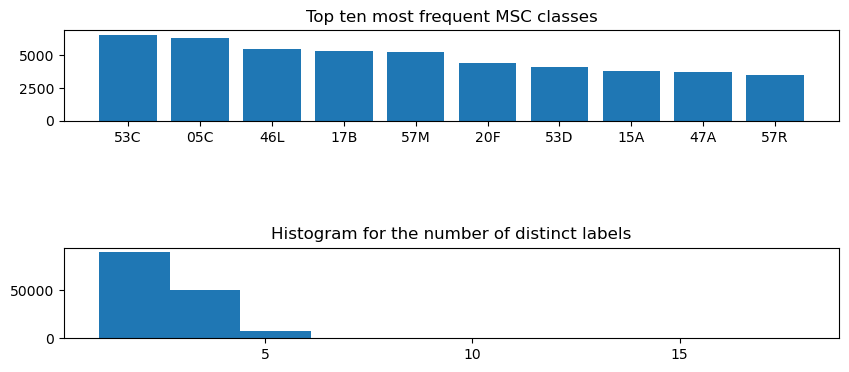

In [5]:
fig=plt.figure(figsize=(10,4))


#Top 10 most frequent MSC classes (bar chart)
ax1=fig.add_subplot(3,1,1)
top_index=np.argsort(-np.asarray(list(dict_MSC.values())))[0:10]
ax1.bar(x=np.asarray(list(dict_MSC.keys()))[top_index],
        height=np.asarray(list(dict_MSC.values()))[top_index])
ax1.set_title('Top ten most frequent MSC classes')

#Number of labels (histogram)
ax2=fig.add_subplot(3,1,3)
ax2.hist(num_labels)
ax2.locator_params(axis='x', integer=True)
ax2.set_title('Histogram for the number of distinct labels')

plt.show()